In [1]:
import sys

# Define the branch you want to install from
branch = "master"

# Install dependencies whether in Colab or not
#!pip install --quiet --upgrade jsonschema
#!pip install --quiet git+https://github.com/yoseflab/hotspot@$branch
#!pip install --quiet scanpy
#!pip install --quiet muon
#!pip install --quiet mplscience

In [2]:
import warnings; warnings.simplefilter('ignore')

import hotspot
import scanpy as sc
# import muon as mu

import numpy as np
import mplscience

import matplotlib.pyplot as plt

In [26]:
# Load the .h5ad file
adata_cd4 = sc.read('/gpfs/data/yanailab/projects/dl4564/PTOI/objects/Complete.Malignant.h5ad')

In [27]:
adata_cd4.layers["counts"] = adata_cd4.raw.X
sc.pp.filter_genes(adata_cd4, min_cells=1)
sc.pp.normalize_total(adata_cd4)
sc.pp.log1p(adata_cd4)
adata_cd4.layers["log_normalized"] = adata_cd4.X.copy()
sc.pp.scale(adata_cd4)
sc.tl.pca(adata_cd4)

<Figure size 640x480 with 0 Axes>

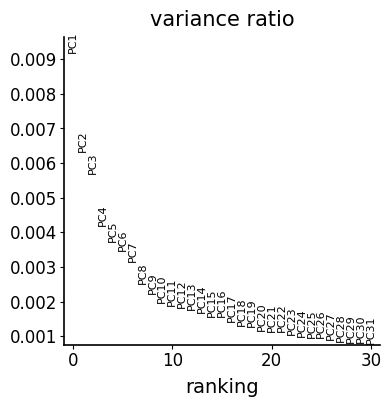

In [28]:
with mplscience.style_context():
    sc.pl.pca_variance_ratio(adata_cd4)

In [29]:
# rerun with fewer components
sc.tl.pca(adata_cd4, n_comps=10)

In [37]:
# Create the Hotspot object and the neighborhood graph
# hotspot works a lot faster with a csc matrix!
adata_cd4.layers["counts_csc"] = adata_cd4.layers["counts"].tocsc()
hs = hotspot.Hotspot(
    adata_cd4,
    layer_key="counts_csc",
    model='danb',
    latent_obsm_key="X_pca",
    umi_counts_obs_key="nCount_RNA"
)

hs.create_knn_graph(
    weighted_graph=False, n_neighbors=50,
)

In [38]:
hs_results = hs.compute_autocorrelations(jobs=4)

#hs_results.head(15)

100%|██████████| 22646/22646 [00:44<00:00, 509.53it/s]


In [39]:
# Select the genes with significant lineage autocorrelation
hs_genes = hs_results.loc[hs_results.FDR < 0.05].sort_values('Z', ascending=False).head(2000).index

# Compute pair-wise local correlations between these genes
lcz = hs.compute_local_correlations(hs_genes, jobs=4)


Computing pair-wise local correlation on 2000 features...


 57%|█████▋    | 1143338/1999000 [29:55<22:23, 636.89it/s]  
Process ForkPoolWorker-23:
Process ForkPoolWorker-21:
Process ForkPoolWorker-22:
Process ForkPoolWorker-24:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/gpfs/share/apps/anaconda3/gpu/new/envs/scvitools/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/gpfs/share/apps/anaconda3/gpu/new/envs/scvitools/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/gpfs/share/apps/anaconda3/gpu/new/envs/scvitools/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/gpfs/share/apps/anaconda3/gpu/new/envs/scvitools/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()


KeyboardInterrupt: 

In [ ]:
modules = hs.create_modules(
    min_gene_threshold=15, core_only=True, fdr_threshold=0.05
)

modules.value_counts()

In [ ]:
hs.plot_local_correlations(vmin=-12, vmax=12)
plt.show()
#plt.savefig("/gpfs/data/yanailab/projects/dl4564/PTOI/modules/Malignant/Complete.hotspot.modules.plot_local_correlations.png")

In [36]:
modules.to_csv('/gpfs/data/yanailab/projects/dl4564/PTOI/modules/Malignant/Complete.hotspot.modules.csv', header=True)  # Add header=True to include a column header